<a href="https://colab.research.google.com/github/ccarpenterg/LearningMXNet/blob/master/04_plotting_accuracy_loss_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plotting Loss and Accuracy with MXNet and Matplotlib

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!pip install mxnet-cu100

In [15]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import statistics

print(mx.__version__)

1.5.1


In [0]:
def normalization(data):
    return nd.moveaxis(data, 2, 0).astype('float32') / 255

MNIST = gluon.data.vision.MNIST

train_data = MNIST(
    train=True
).transform_first(
    normalization
)

valid_data = MNIST(
    train=False
).transform_first(
    normalization
)

In [0]:
train_loader = gluon.data.DataLoader(train_data, shuffle=True, batch_size=64)
valid_loader = gluon.data.DataLoader(valid_data, shuffle=False, batch_size=64)

In [0]:
convnet = nn.Sequential()

convnet.add(
    nn.Conv2D(channels=32, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2),
    nn.Conv2D(channels=64, kernel_size=3, activation='relu'),
    nn.MaxPool2D(pool_size=2),
    nn.Conv2D(channels=64, kernel_size=3, activation='relu'),
    nn.Dense(64, activation='relu'),
    nn.Dense(10)
)

In [0]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
convnet.initialize(mx.init.Xavier(), ctx=ctx)

In [0]:
trainer = gluon.Trainer(
    params=convnet.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04}
)

In [0]:
def train(model, loss_function, optimizer):
    
    train_batch_losses = []
    
    for batch, labels in train_loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        with autograd.record():
            
            output = model(batch)
            loss = loss_function(output, labels)
            
        loss.backward()
        optimizer.step(batch_size=batch.shape[0])
        
        train_batch_losses.append(float(nd.sum(loss).asscalar()))
        
    mean_loss = statistics.mean(train_batch_losses)
    
    return mean_loss       

In [0]:
def validate(model, loss_function, optimizer):
    
    validation_batch_losses = []
    
    for batch, labels in valid_loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        output = model(batch)
        loss = loss_function(output, labels)
        
        validation_batch_losses.append(float(nd.sum(loss).asscalar()))
        
        mean_loss = statistics.mean(validation_batch_losses)
        
    return mean_loss

In [0]:
def accuracy(model, loader):
    
    metric = mx.metric.Accuracy()
    
    for batch, labels in loader:
        batch = batch.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        
        class_probabilities = nd.softmax(model(batch), axis=1)
        predictions = nd.argmax(class_probabilities, axis=1)
        
        metric.update(labels, predictions)
        
    _, accuracy_metric = metric.get()
    
    return accuracy_metric

In [0]:
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()

epochs = 10

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(1, 1 + epochs):
    train_loss = train(convnet, loss_function, trainer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(convnet, train_loader)
    train_accuracies.append(train_accuracy)
    
    valid_loss = validate(convnet, loss_function, trainer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(convnet, valid_loader)
    valid_accuracies.append(valid_accuracy)

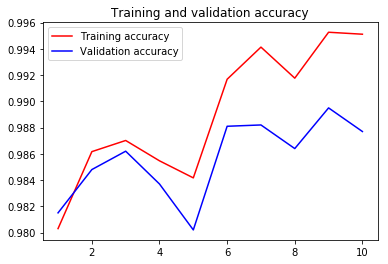

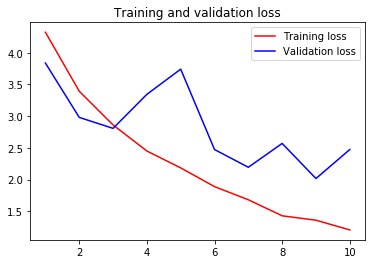

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, epochs + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
